<a href="https://colab.research.google.com/github/Seanmullan/SDP/blob/vision/Copy_of_colab_vgg_direct_save_top_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import applications

from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
#   f.write('Hello Google Drive!')
# !cat /content/gdrive/My\ Drive/foo.txt
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive2 = GoogleDrive(gauth)

In [0]:
import numpy as np
import cv2
from matplotlib import pyplot as plt 
img = cv2.imread('/afs/inf.ed.ac.uk/user/s18/s1891132/Downloads/testgrab.jpg')
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,50,200,550)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

lower_bound = np.array([0, 0, 0])
upper_bound = np.array([30, 30, 30])
mask = cv2.inRange(img, lower_bound, upper_bound)
mask_inv = cv2.bitwise_not(mask)
fg = cv2.bitwise_and(img, img, mask=mask_inv)
fg[mask == 255] = (255, 255, 255)

cv2.imshow("img",fg)
cv2.waitKey(0)

In [0]:

# img_data_list=[]
# classsize = []
# for dataset in data_dir_list:
#     img_list=os.listdir(data_path+'/'+ dataset)
#     classsize.append(len(img_list))
#     print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
#     for img in img_list:
#         img_path = data_path + '/'+ dataset + '/'+ img
#         img = image.load_img(img_path, target_size=(224, 224))
#         x = image.img_to_array(img)
#         x = np.expand_dims(x, axis=0)
#         x = preprocess_input(x)
#         #x = x/255 should we do this in preprocession?
#         #print('Input image shape:', x.shape)
#         img_data_list.append(x)

# # x is the last vector of the image
# #print(x)
# img_data = np.array(img_data_list)
# #img_data = img_data.astype('float32')
# print (img_data.shape)
# img_data=np.rollaxis(img_data,1,0)
# print (img_data.shape)
# img_data=img_data[0]
# print (img_data.shape)


In [0]:
# from google.colab import files
# uploaded = files.upload()

# from keras.models import load_model
# model = load_model('model.h5')

In [4]:

# Define the number of classes change this code condition to the number of classes.
# Loading the training data
PATH = os.getcwd()
print(PATH)
# Define data path
data_path = PATH + '/gdrive/My Drive/sdp/dataset_new'
data_dir_list =['glass', 'metal',  'plastic' ] # LETS  start with the sample version 
data_dir_list_testintrain =['glass_done', 'metal_done',  'plastic_done' ] # LETS  start with the sample version 

#define parameters here
img_width, img_height = 150, 150

epochs = 80
batch_size = 32
train_data_dir = data_path+'/train_gray'
validation_data_dir = data_path+'/validation_gray'
testing_data_dir = data_path + "/wholeset"

#check dataset size
classsize = []
for dataset in data_dir_list:
    img_list=os.listdir(train_data_dir+'/'+ dataset)
    classsize.append(len(img_list))
# for dataset in data_dir_list:
#     img_list=os.listdir(testing_data_dir+'/'+ dataset)
#     classsize.append(len(img_list))

#assign labels    
num_classes = 3
train_labels = np.ones((np.sum(classsize),),dtype='int64')
train_labels[0:classsize[0]]=0
train_labels[classsize[0]:classsize[0]+classsize[1]]=1
train_labels[classsize[0]+classsize[1]:]=2

# !!!!! this part only is added for the test set in training set.!!!!!
# train_labels[np.sum(classsize[:3]):np.sum(classsize[:4])]=0
# train_labels[np.sum(classsize[:4]):np.sum(classsize[:5])]=1
# train_labels[np.sum(classsize[:5]):]=2

nb_train_samples = np.sum(classsize)



classsize = []
for dataset in data_dir_list:
    img_list=os.listdir(validation_data_dir+'/'+ dataset)
    classsize.append(len(img_list))
    
validation_labels = np.ones((np.sum(classsize),),dtype='int64')
validation_labels[0:classsize[0]]=0
validation_labels[classsize[0]:classsize[0]+classsize[1]]=1
validation_labels[classsize[0]+classsize[1]:]=2
names = ['glass', 'metal',  'plastic' ]


nb_validation_samples = np.sum(classsize)


classsize = []
for dataset in data_dir_list:
    img_list=os.listdir(testing_data_dir+'/'+ dataset)
    classsize.append(len(img_list))
    
test_labels = np.ones((np.sum(classsize),),dtype='int64')
test_labels[0:classsize[0]]=0
test_labels[classsize[0]:classsize[0]+classsize[1]]=1
test_labels[classsize[0]+classsize[1]:]=2
names = ['glass', 'metal',  'plastic' ]


nb_testing_samples = np.sum(classsize)


# convert class labels to on-hot encoding
Y_train = np_utils.to_categorical(train_labels, num_classes)
Y_validation = np_utils.to_categorical(validation_labels, num_classes)

Y_test = np_utils.to_categorical(test_labels, num_classes)
# #Shuffle the dataset
# x,y = shuffle(img_data,Y, random_state=2)
# # Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)






#define all strings here:



bottleneck_train_name="bottleneck_features_vgg_validation_20190312.npy"
bottleneck_validation_name="bottleneck_features_vgg_train_20190312.npy"
bottleneck_test_name="bottleneck_features_vgg_test_20190312.npy"

top_model_weights_path = 'vgg_top_model_weight_20190312.h5'
top_model_name='vgg_top_model_20190312.h5'
top_model_train_history='history_vgg_top_model_20190312.npy'
top_model_weights_path_test = 'vgg_top_model_weight_test_20190312.h5'
top_model_name_test='vgg_top_model_test_20190312.h5'
top_model_train_history_test='history_vgg_top_model_test_20190312.npy'

retrain_model_name='vgg16_retrain_model_20190312.h5'
retrain_model_weight="vgg_retrain_weight_20190312.h5"
retrain_model_history='vgg_retrain_history_20190312.npy'
retrain_model_name_test='vgg16_retrain_model_test_20190312.h5'
retrain_model_weight_test="vgg_retrain_weight_test_20190312.h5"
retrain_model_history_test='vgg_retrain_history_test_20190312.npy'

top_model_id,top_model_weight_id,top_model_history_id='1cZe_3OMAzRGgDhRyXDvgZF7JAZ17V3KP',"16ld30JlGe-z5wRAxQt3YT4fZu_cjHo3q",'1AD7tD-rpt9Vt5t-g7lZtcRMS_JNkA3Vm'
retrain_model_id,retrain_model_weight_id,retrain_model_history_id='1ASgzfs4DuWqt3Ybdqvf7-3gmipIAxuJk',"1AFJSCMJ4nFrvT5I4Hh1tKHBd1IdhMXJc",'1kqkVCEG6x-rfoFclGZKS67ts_ZChAdqG'



/content


In [0]:
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def convert(image_paths, labels, out_path):
    # Args:
    # image_paths   List of file-paths for the images.
    # labels        Class-labels for the images.
    # out_path      File-path for the TFRecords output file.
    
    print("Converting: " + out_path)
    
    # Number of images. Used when printing the progress.
    num_images = len(image_paths)
    
    # Open a TFRecordWriter for the output-file.
    with tf.python_io.TFRecordWriter(out_path) as writer:
        
        # Iterate over all the image-paths and class-labels.
        for i, (path, label) in enumerate(zip(image_paths, labels)):
            # Print the percentage-progress.
            print_progress(count=i, total=num_images-1)

            # Load the image-file using matplotlib's imread function.
            img = imread(path)
            
            # Convert the image to raw bytes.
            img_bytes = img.tostring()

            # Create a dict with the data we want to save in the
            # TFRecords file. You can add more relevant data here.
            data = \
                {
                    'image': wrap_bytes(img_bytes),
                    'label': wrap_int64(label)
                }

            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)

            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)

            # Serialize the data.
            serialized = example.SerializeToString()
            
            # Write the serialized data to the TFRecords file.
            writer.write(serialized)
            
            
def parse(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    # It is a bit awkward that this needs to be specified again,
    # because it could have been written in the header of the
    # TFRecords file instead.
    features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }

    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.parse_single_example(serialized=serialized,
                                             features=features)

    # Get the image as raw bytes.
    image_raw = parsed_example['image']

    # Decode the raw bytes so it becomes a tensor with type.
    image = tf.decode_raw(image_raw, tf.uint8)
    
    # The type is now uint8 but we need it to be float.
    image = tf.cast(image, tf.float32)

    # Get the label associated with the image.
    label = parsed_example['label']

    # The image and label are now correct TensorFlow types.
    return image, label

In [0]:
#########################################################################################
# Custom_vgg_model_1
#Training the classifier alone
# image_input = Input(shape=(224, 224, 3))

# model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')
# model.summary()
# last_layer = model.get_layer('fc2').output
# #x= Flatten(name='flatten')(last_layer)
# out = Dense(num_classes, activation='softmax', name='output')(last_layer)
# custom_vgg_model = Model(image_input, out)
# custom_vgg_model.summary()

# for layer in custom_vgg_model.layers[:-1]:
#     layer.trainable = False

# custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])


# t=time.time()
# #t = now()
# hist2 = custom_vgg_model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=1, validation_data=(X_test, y_test))
# print('Training time: %s' % (t - time.time()))
# (loss2, accuracy2) = custom_vgg_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

# print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss2,accuracy2 * 100))

from tensorflow.keras.models import Sequential
#import tensorflow.keras.backend as K
#from tensorflow.contrib.data import Dataset



#download and unzip the training/validation dataset, use it to create a generator
def preparegenerator():
     
    
    !unzip ~/gdrive/My Drive/traintrain.tfrecords.zip
    
    dataset = tf.data.TFRecordDataset(filenames="traintrain.tfrecords")

    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(parse)        
    







    #be aware, run this model once to heat up the generator before you run any other model that needs to use the generator
    #...god I have to change this
    #this should take aproperiatly 30min to run?
    #this does not save to google drive, but only to colab directory
def save_bottlebeck_features_train():
    #datagen = ImageDataGenerator()
    datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0,
    height_shift_range=0, 
    shear_range=0, 
    zoom_range=[0.8,0.8],
    brightness_range=[0.75,1.2],
    horizontal_flip=True,
    fill_mode='nearest')
#     image_input = Input(shape=(224, 224, 3))
#     model = VGG16(input_tensor=image_input,include_top=False, weights='imagenet')

    # build the VGG16 network
    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples*5 // batch_size)
    np.save(open(bottleneck_train_name, 'wb'),
            bottleneck_features_train)
def save_bottlebeck_features():
    #datagen = ImageDataGenerator()
    datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0,
    height_shift_range=0, 
    shear_range=0, 
    zoom_range=[0.8,0.8],
    brightness_range=[0.75,1.2],
    horizontal_flip=True,
    fill_mode='nearest')
#     image_input = Input(shape=(224, 224, 3))
#     model = VGG16(input_tensor=image_input,include_top=False, weights='imagenet')

    # build the VGG16 network
    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,

        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open(bottleneck_train_name, 'wb'),
            bottleneck_features_train)
    
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open(bottleneck_validation_name, 'wb'),
            bottleneck_features_validation)
    
def save_bottlebeck_features_validation():
    datagen = ImageDataGenerator()
#     image_input = Input(shape=(224, 224, 3))
#     model = VGG16(input_tensor=image_input,include_top=False, weights='imagenet')

    # build the VGG16 network
    model = VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open(bottleneck_validation_name, 'wb'),
            bottleneck_features_validation)
     
def save_bottlebeck_features_test():
    datagen = ImageDataGenerator()
    
#     image_input = Input(shape=(224, 224, 3))
#     model = VGG16(input_tensor=image_input,include_top=False, weights='imagenet')

    # build the VGG16 network
    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        testing_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_test = model.predict_generator(
        generator, nb_testing_samples // batch_size)
    np.save(open(bottleneck_test_name, 'wb'),
            bottleneck_features_test)
    
    

    
    


def train_top_model(with_regularization,optimizer):
    X_train = np.load(open(bottleneck_train_name,'rb'))
    X_validation = np.load(open(bottleneck_validation_name,'rb'))
    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    if(not with_regularization):
      model.add(Dense(256, activation='relu'))
    else:
      model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax', name='output'))

    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

    X_train,y_train = shuffle(X_train,Y_train, random_state=2)
    X_validation,y_validation = shuffle(X_validation,Y_validation, random_state=2)
    history=model.fit(X_train, y_train,
              epochs=epochs,
              batch_size=batch_size,
              verbose=1,
              validation_data=(X_validation, y_validation))
    model.save_weights(top_model_weights_path)
    model.save(top_model_name) 
    
    return history,model
def train_top_model_validate_with_test(with_regularization,optimizer):
    X_train = np.load(open(bottleneck_train_name,'rb'))
    X_test = np.load(open(bottleneck_test_name,'rb'))
    print(X_train.shape)
    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    if(not with_regularization):
      model.add(Dense(256, activation='relu'))
    else:
      model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax', name='output'))

    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

    X_train,y_train = shuffle(X_train,Y_train, random_state=2)
    X_test,y_test = shuffle(X_test,Y_test, random_state=2)
    history=model.fit(X_train, y_train,
              epochs=epochs,
              batch_size=batch_size,
              verbose=1,
              validation_data=(X_test, y_test))
    model.save_weights(top_model_weights_path_test)
    model.save(top_model_name_test) 
    
    return history,model

############################################################################################
# visualizing losses and accuracy
def plot_history(history,epochs,history_name):
    train_loss2=history.history['loss']
    val_loss2=history.history['val_loss']
    train_acc2=history.history['acc']
    val_acc2=history.history['val_acc']
    xc=range(epochs)
    with open(history_name, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss2)
    plt.plot(xc,val_loss2)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train_loss vs val_loss')
    plt.grid(True)
    plt.legend(['train','val'])
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc2)
    plt.plot(xc,val_acc2)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train_acc vs val_acc')
    plt.grid(True)
    plt.legend(['train','val'],loc=4)
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])
def plot_history_history(history,epochs,history_name):
    train_loss2=history['loss']
    val_loss2=history['val_loss']
    train_acc2=history['acc']
    val_acc2=history['val_acc']
    xc=range(epochs)
    with open(history_name, 'wb') as file_pi:
        pickle.dump(history, file_pi)
    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss2)
    plt.plot(xc,val_loss2)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train_loss vs val_loss')
    plt.grid(True)
    plt.legend(['train','val'])
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc2)
    plt.plot(xc,val_acc2)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train_acc vs val_acc')
    plt.grid(True)
    plt.legend(['train','val'],loc=4)
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])
    # this does not save the bottle neck assume already load drive
    # the parameters are the name of the files to save
def save_model_weights_history_to_drive(model_file_name,top_model_weights_path,train_history):
    model_file = drive2.CreateFile({'title' : model_file_name})
    model_file.SetContentFile(model_file_name)
    model_file.Upload()
    # download to google drive
    drive2.CreateFile({'id': model_file.get('id')})

    weight_file = drive2.CreateFile({'title' : top_model_weights_path})
    weight_file.SetContentFile(top_model_weights_path)
    weight_file.Upload()

    # download to google drive
    drive2.CreateFile({'id': weight_file.get('id')})

    history_file = drive2.CreateFile({'title' : train_history})
    history_file.SetContentFile(train_history)
    history_file.Upload()

    # download to google drive
    drive2.CreateFile({'id': history_file.get('id')})
    
    
    #load model and history from google drive by id , could improve by using name
def load_model_weights_history(model_file_id,top_model_weights_id,train_history_id):

    if(model_file_id!=None):
        model_file = drive2.CreateFile({'id' : model_file_id})
        print (model_file['title'])  # UMNIST.zip

        model_file.GetContentFile(model_file['title'])  # Save Drive file as a local file
    
    if(top_model_weights_id!=None):

        weight_file = drive2.CreateFile({'id' : top_model_weights_id})
        print( weight_file['title'])  # UMNIST.zip

        weight_file.GetContentFile(weight_file['title'])  # Save Drive file as a local file
        
    if(train_history_id!=None):
        history_file = drive2.CreateFile({'id' : train_history_id})
        print (history_file['title'])  # UMNIST.zip

        history_file.GetContentFile(history_file['title'])  # Save Drive file as a local file

    #return model_file,weight_file,history_file
def load_item_to_colab(itemid):     
    if(itemid!=None):
        item_file = drive2.CreateFile({'id' : itemid})
        print (model_file['title'])  # UMNIST.zip

        item_file.GetContentFile(item_file['title'])  # Save Drive file as a local file
        
def save_item_to_googledrive(item_name):
    item_file = drive2.CreateFile({'title' : item_name})
    item_file.SetContentFile(item_name)
    item_file.Upload()
    # download to google drive
    drive2.CreateFile({'id': item_file.get('id')})
    
    
    
    #assuming same top layer structure as in train_top_model. this is stupid as I cant change the hidden layer design,
    #but still leave a reasonable amount of hyperparameter to change considering the amount of computational resource I have
    
def retrain_layers(top_model_weights_path,with_regularization):

#     # build the VGG16 network
#     model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
#     print('Model loaded.')

#     # build a classifier model to put on top of the convolutional model
#     top_model = Sequential()
#     top_model.add(Flatten(input_shape=model.output_shape[1:]))
#     top_model.add(Dense(256, activation='relu'))

# #     top_model.add(Dense(256, input_shape=model.output_shape[1:],activation='relu'))
#     top_model.add(Dropout(0.5))
#     top_model.add(Dense(num_classes, activation='softmax'))
        
# #     model.add(Flatten(input_shape=X_train.shape[1:]))
# #     model.add(Dropout(0.5))
# #     model.add(Dense(num_classes, activation='softmax', name='output'))
#     # note that it is necessary to start with a fully-trained
#     # classifier, including the top classifier,
#     # in order to successfully do fine-tuning
    input_tensor = Input(shape=(150,150,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    if(not with_regularization):
      top_model.add(Dense(256, activation='relu'))
    else:
      top_model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(num_classes, activation='softmax'))
    top_model.load_weights(top_model_weights_path)
    model = Model(inputs= base_model.input, outputs= top_model(base_model.output))
#     Model()
#     # add the model on top of the convolutional base
#    model.add(top_model)
    print(model.summary())
    # set the first 15 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    # check the model to make sure which block to retrain here.
    for layer in model.layers[:15]:
        layer.trainable = False
    return model
    
    #load the data from the google drive. slow, use only a small portion of gpu power I have. might improve using tf records
def compile_train_transferlearning(model):
      # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    datagen = ImageDataGenerator()
    train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False)

    validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    # fine-tune the model
    history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples// batch_size)
    
    return model,history
def compile_train_transferlearning_against_test(model):
      # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    datagen = ImageDataGenerator()
    train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False)

    test_generator = datagen.flow_from_directory(
        testing_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    # fine-tune the model
    history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=test_generator,
        validation_steps=nb_testing_samples// batch_size)
    
    return model,history
    #again assuming same top layer structures as in train top model
    #using hyperparameter search by hyperas, not able to change hidden layer is all
def hyperparameter_search(top_model_weights_path):
    input_tensor = Input(shape=(img_width, img_height,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(num_classes, activation='softmax'))
    top_model.load_weights(top_model_weights_path)
    model = Model(inputs= base_model.input, outputs= top_model(base_model.output))
    for layer in model.layers[:15]:
        layer.trainable = False
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    datagen = ImageDataGenerator()
    train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False)

    validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    # fine-tune the model
    history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples// batch_size)
    
    return model,history


In [0]:
#!unzip gdrive/My\ Drive/traintrain.tfrecords.zip
# file = open("Fruits.obj",'r')
# object_file = pickle.load(file)

Archive:  gdrive/My Drive/traintrain.tfrecords.zip
  inflating: traintrain.tfrecords    


In [6]:
save_bottlebeck_features_train()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step
Found 1237 images belonging to 3 classes.


In [7]:
save_bottlebeck_features_test()

Found 157 images belonging to 3 classes.


In [0]:
epochs=100
history,model=train_top_model(False,"rmsprop")


Train on 14798 samples, validate on 2905 samples
Epoch 1/100
14798/14798 [==============================] - 4s 268us/sample - loss: 8.5468 - acc: 0.4620 - val_loss: 8.5046 - val_acc: 0.4606
Epoch 2/100
14798/14798 [==============================] - 4s 243us/sample - loss: 7.5035 - acc: 0.5251 - val_loss: 8.2418 - val_acc: 0.4840
Epoch 3/100
14798/14798 [==============================] - 4s 238us/sample - loss: 7.0304 - acc: 0.5559 - val_loss: 7.4616 - val_acc: 0.5322
Epoch 4/100
14798/14798 [==============================] - 4s 240us/sample - loss: 6.5681 - acc: 0.5868 - val_loss: 7.8372 - val_acc: 0.5112
Epoch 5/100
14798/14798 [==============================] - 4s 240us/sample - loss: 6.4896 - acc: 0.5920 - val_loss: 6.9614 - val_acc: 0.5625
Epoch 6/100
14798/14798 [==============================] - 4s 248us/sample - loss: 6.3348 - acc: 0.6014 - val_loss: 7.0193 - val_acc: 0.5580
Epoch 7/100
14798/14798 [==============================] - 4s 239us/sample - loss: 6.1900 - acc: 0.6099 -

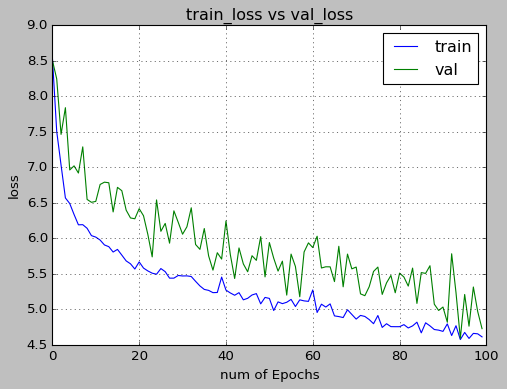

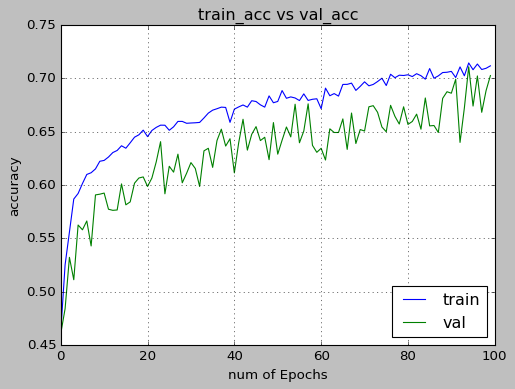

In [0]:
plot_history(history,epochs,top_model_train_history)
# save_model_weights_history_to_drive(top_model_name,top_model_weights_path,top_model_train_history)

In [10]:
epochs=150
history2,model2=train_top_model_validate_with_test(False,"rmsprop")


Train on 1237 samples, validate on 157 samples
Epoch 1/150
1237/1237 [==============================] - 0s 381us/sample - loss: 8.7076 - acc: 0.4285 - val_loss: 6.9585 - val_acc: 0.5669
Epoch 2/150
1237/1237 [==============================] - 0s 222us/sample - loss: 7.5899 - acc: 0.5061 - val_loss: 6.8307 - val_acc: 0.5669
Epoch 3/150
1237/1237 [==============================] - 0s 216us/sample - loss: 7.4349 - acc: 0.5198 - val_loss: 7.9213 - val_acc: 0.4904
Epoch 4/150
1237/1237 [==============================] - 0s 223us/sample - loss: 6.1324 - acc: 0.6015 - val_loss: 6.6487 - val_acc: 0.5669
Epoch 5/150
1237/1237 [==============================] - 0s 222us/sample - loss: 6.1445 - acc: 0.6055 - val_loss: 6.6252 - val_acc: 0.5860
Epoch 6/150
1237/1237 [==============================] - 0s 242us/sample - loss: 5.7406 - acc: 0.6289 - val_loss: 6.3452 - val_acc: 0.5924
Epoch 7/150
1237/1237 [==============================] - 0s 260us/sample - loss: 5.3603 - acc: 0.6540 - val_loss: 6.719

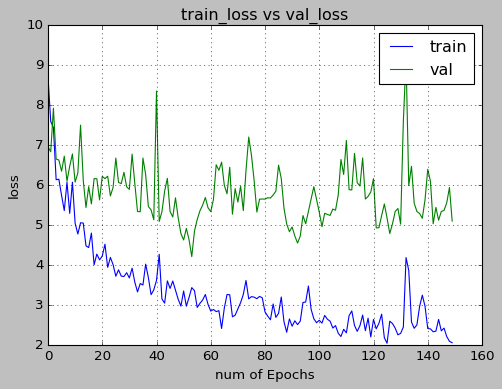

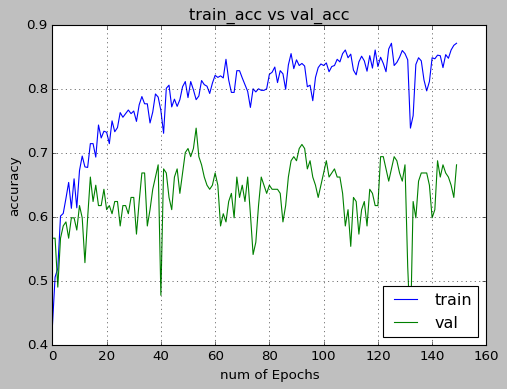

In [11]:
plot_history(history2,epochs,top_model_train_history_test)


In [0]:
save_model_weights_history_to_drive(top_model_name_test,top_model_weights_path_test,top_model_train_history_test)

In [0]:
#load_model_weights_history('1cZe_3OMAzRGgDhRyXDvgZF7JAZ17V3KP',"16ld30JlGe-z5wRAxQt3YT4fZu_cjHo3q",'1AD7tD-rpt9Vt5t-g7lZtcRMS_JNkA3Vm')

vgg16_direct.h5
bottleneck_vgg_model.h5
history_vgg_direct.npy


In [0]:
trained_model =retrain_layers(top_model_weights_path,False)
trained_model2 =retrain_layers(top_model_weights_path_test,False)
#retrained_model,retrain_history=compile_train(trained_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
# trained_model.layers[15]
#trained_model.save_weights("bottleneck_vgg_model2.h5")


In [0]:
#change batch size to make the training faster, can be replaced after loading data to tensorflow records
batch_size=64
epochs=50
retrained_model,retrain_history=compile_train_transferlearning(trained_model)

Found 14798 images belonging to 3 classes.
Found 2905 images belonging to 3 classes.
Epoch 1/50
232/232 [==============================] - 131s 563ms/step - loss: 10.5766 - acc: 0.3416 - val_loss: 10.4571 - val_acc: 0.3425
Epoch 2/50
232/232 [==============================] - 129s 556ms/step - loss: 10.5766 - acc: 0.3416 - val_loss: 10.4571 - val_acc: 0.3425
Epoch 3/50
232/232 [==============================] - 129s 555ms/step - loss: 10.5766 - acc: 0.3416 - val_loss: 10.4571 - val_acc: 0.3425
Epoch 4/50
232/232 [==============================] - 129s 554ms/step - loss: 10.5766 - acc: 0.3416 - val_loss: 10.4571 - val_acc: 0.3425
Epoch 5/50
232/232 [==============================] - 129s 555ms/step - loss: 10.5766 - acc: 0.3416 - val_loss: 10.4571 - val_acc: 0.3425
Epoch 6/50
232/232 [==============================] - 129s 556ms/step - loss: 10.5766 - acc: 0.3416 - val_loss: 10.4571 - val_acc: 0.3425
Epoch 7/50
232/232 [==============================] - 129s 555ms/step - loss: 10.5766 -

In [0]:
def save_all(model,history,model_file_name,top_model_weights_path,train_history):
    model.save_weights(top_model_weights_path)
    model.save(model_file_name) 
    with open(train_history, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    save_model_weights_history_to_drive(model_file_name,top_model_weights_path,train_history)

save_all(retrained_model,retrain_history,retrain_model_name,retrain_model_weight,retrain_model_history)

In [0]:
load_model_weights_history('1cZe_3OMAzRGgDhRyXDvgZF7JAZ17V3KP',"16ld30JlGe-z5wRAxQt3YT4fZu_cjHo3q",'1AD7tD-rpt9Vt5t-g7lZtcRMS_JNkA3Vm')


vgg16_direct.h5
bottleneck_vgg_model.h5
history_vgg_direct.npy


In [0]:
trained_model =retrain_layers(top_model_weights_path)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
load_model_weights_history('1ASgzfs4DuWqt3Ybdqvf7-3gmipIAxuJk',"1AFJSCMJ4nFrvT5I4Hh1tKHBd1IdhMXJc",'1kqkVCEG6x-rfoFclGZKS67ts_ZChAdqG')

vgg16_retrain_model.h5
vgg_retrain_weight.h5
vgg_retrain_history.npy


In [0]:
trained_model.load_weights(retrain_model_weight)
trained_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])

In [0]:
#def testsetperformance():
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
#load the weight  need to store the weight first!!
def accandconfusion(weigts_path,directory):
    input_tensor = Input(shape=(img_width, img_height,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(num_classes, activation='softmax'))
    top_model.load_weights(weigts_path)
    model = Model(inputs= base_model.input, outputs= top_model(base_model.output))
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
#     generator = datagen.flow_from_directory(
#         train_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode=None,
#         shuffle=False)
#     bottleneck_features_train = model.predict_generator(
#         generator, nb_train_samples // batch_size)
    
    
    
#     optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    img_data_list=[]
    classsize = []
    print(directory)
    for dataset in data_dir_list:
        img_list=os.listdir(directory+'/'+ dataset)
        img_list=img_list[:100]
        classsize.append(len(img_list))
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            #print(img)
            img_path = directory + '/'+ dataset + '/'+ img
            img = image.load_img(img_path, target_size=(img_width, img_height))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            #x = x/255 should we do this in preprocession?
            #print('Input image shape:', x.shape)
            img_data_list.append(x)


    img_data = np.array(img_data_list)
    #img_data = img_data.astype('float32')
    print (img_data.shape)
    img_data=np.rollaxis(img_data,1,0)
    print (img_data.shape)
    img_data=img_data[0]
    print (img_data.shape)        



    test_labels = np.ones((np.sum(classsize),),dtype='int64')
    test_labels[0:classsize[0]-1]=0
    test_labels[classsize[0]:classsize[0]+classsize[1]-1]=1
    test_labels[classsize[0]+classsize[1]:]=2        
    nb_testing_samples = np.sum(classsize)

    # convert class labels to on-hot encoding
    Y_test = np_utils.to_categorical(test_labels, num_classes)        
    x,y = shuffle(img_data,Y_test, random_state=2)
    (loss, accuracy) = model.evaluate(x, y, batch_size=12, verbose=1)
    print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))
    y_pred= model.predict(x)
    cm = confusion_matrix(np.argmax(y,1), np.argmax(y_pred,1))
    #cm = cm / np.sum(cm,1)
    plt.figure()
    xticks =data_dir_list
    plt.title("confusion matrix of resnet with retraining")
    heatmap = sns.heatmap(cm, xticklabels=data_dir_list,yticklabels=data_dir_list,annot=True, )
    plt.show() 

In [16]:
accandconfusion(top_model_weights_path,testing_data_dir)

OSError: ignored

/content/gdrive/My Drive/sdp/dataset_new/test_real
Loaded the images of dataset-glass

Loaded the images of dataset-metal

Loaded the images of dataset-plastic

(300, 1, 150, 150, 3)
(1, 300, 150, 150, 3)
(300, 150, 150, 3)
300/300 [==============================] - 2s 8ms/sample - loss: 11.1284 - acc: 0.3067
[INFO] loss=11.1284, accuracy: 30.6667%


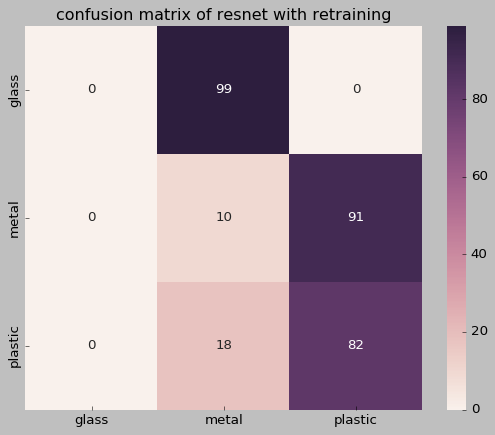

In [0]:
accandconfusion(top_model_weights_path_test,testing_data_dir)

In [12]:
testingaccandconfusion()

NameError: ignored

Loaded the images of dataset-glass

Loaded the images of dataset-metal

Loaded the images of dataset-plastic

(506, 1, 150, 150, 3)
(1, 506, 150, 150, 3)
(506, 150, 150, 3)
506/506 [==============================] - 5s 9ms/sample - loss: 10.0658 - acc: 0.3755
[INFO] loss=10.0658, accuracy: 37.5494%


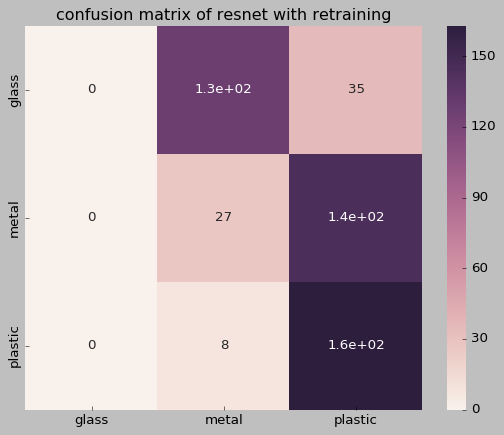

In [0]:
testingaccandconfusion()

In [0]:
def predict(top_model,img_data):
#     img_data = preprocess_input(img_data)
#     img_data=np.rollaxis(img_data,1,0)
#     img_data=img_data[0]
    feature = VGG16(include_top=False, weights='imagenet').predict(img_data)
    output=top_model.predict(feature)
    return np.argmax(output)

def test(model,img_path):
    img_data_list=[]            
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
            #x = x/255 should we do this in preprocession?
            #print('Input image shape:', x.shape)
    img_data_list.append(x)
    img_data = np.array(img_data_list)
    #img_data = img_data.astype('float32')
    print (img_data.shape)
    img_data=np.rollaxis(img_data,1,0)
    print (img_data.shape)
    img_data=img_data[0]
    print (img_data.shape)        
    return predict(model,img_data)

In [0]:
test(model,"glass_0_9371.jpeg")

(1, 1, 150, 150, 3)
(1, 1, 150, 150, 3)
(1, 150, 150, 3)


0

In [0]:
X_train = np.load(open('bottleneck_features_vgg_train.npy','rb'))
X_train.shape


(11612, 4, 4, 512)

157/157 [==============================] - 1s 8ms/sample - loss: 11.9089 - acc: 0.2611


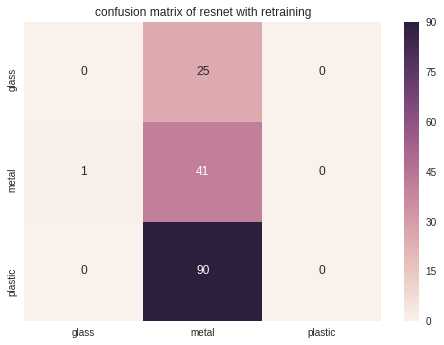

In [0]:
input_tensor = Input(shape=(img_width, img_height,3))
base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation='softmax'))
top_model.load_weights(top_model_weights_path)
model = Model(inputs= base_model.input, outputs= top_model(base_model.output))
model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])
(loss, accuracy) = model.evaluate(x, y, batch_size=12, verbose=1)
y_pred= model.predict(x)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y,1), np.argmax(y_pred,1))
#cm = cm / np.sum(cm,1)
import seaborn as sns
plt.figure()
xticks =data_dir_list
plt.title("confusion matrix of resnet with retraining")
heatmap = sns.heatmap(cm, xticklabels=data_dir_list,yticklabels=data_dir_list,annot=True, )
plt.show() 


In [0]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
print(top_model.output_shape)
top_model.add(Dense(256, activation='relu'))
print(top_model.output_shape)

top_model.add(Dropout(0.5))
print(top_model.output_shape)

top_model.add(Dense(num_classes, activation='softmax'))
print(top_model.output_shape)


(None, 8192)
(None, 256)
(None, 256)
(None, 3)


In [0]:
Y_test.shape

(2905, 3)

In [0]:
l =[1,23,3]

In [0]:
l[:100]

[1, 23, 3]

In [0]:
model